In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## `respevt` 

In [90]:
def read_respevt_txt_to_df(filename):
    respevt_time = []
    respevt_type = []
    respevt_pb_cs = []
    respevt_duration = []
    respevt_desat_low = []
    respevt_desat_drop = []
    respevt_snore = []
    respevt_arousal = []
    respevt_bt_rate = []
    respevt_bt_change = []
    for line_no, line in enumerate(open(filename).readlines()):
        if line_no > 2:
            vals = line.split()
            is_pb = False
            is_no_desaturation = False
            for count, val in enumerate(vals):
                if count == 0 and val != '\x1a':
                    respevt_time.append(val)
                elif count == 1 and val == 'PB':
                    is_pb = True
                    respevt_type.append(val)
                elif count == 1 and val != 'PB':
                    respevt_type.append(val)
                elif count == 2 and is_pb:
                    pass
                elif count == 2 and not is_pb:
                    respevt_pb_cs.append(np.nan)
                    respevt_duration.append(val)
                elif count == 3 and is_pb:
                    respevt_pb_cs.append(val)
                elif count == 3 and not is_pb:
                    if val == '-' or val == '+':
                        respevt_desat_low.append(np.nan)
                        respevt_desat_drop.append(np.nan)
                        respevt_snore.append(val)
                        is_no_desaturation = True
                    else:
                        respevt_desat_low.append(val)
                elif count == 4 and is_pb:
                    respevt_duration.append(val)
                elif count == 4 and not is_pb:
                    if is_no_desaturation:
                        respevt_arousal.append(val)
                    else:
                        respevt_desat_drop.append(val)
                elif count == 5 and is_pb:
                    if val == '-' or val == '+':
                        respevt_desat_low.append(np.nan)
                        respevt_desat_drop.append(np.nan)
                        respevt_snore.append(val)
                        is_no_desaturation = True
                    else:
                        respevt_desat_low.append(val)
                elif count == 5 and not is_pb:
                    if is_no_desaturation:
                        respevt_bt_rate.append(val)
                    else:
                        respevt_snore.append(val)
                elif count == 6 and is_pb:
                    if is_no_desaturation:
                        respevt_arousal.append(val)
                    else:
                        respevt_desat_drop.append(val)
                elif count == 6 and not is_pb:
                    if is_no_desaturation:
                        respevt_bt_change.append(val)
                    else:
                        respevt_arousal.append(val)
                elif count == 7 and is_pb:
                    if is_no_desaturation:
                        respevt_bt_rate.append(val)
                    else:
                        respevt_snore.append(val)
                elif count == 7 and not is_pb:
                    respevt_bt_rate.append(val)
                elif count == 8 and is_pb:
                    if is_no_desaturation:
                        respevt_bt_change.append(val)
                    else:
                        respevt_arousal.append(val)
                elif count == 8 and not is_pb:
                    respevt_bt_change.append(val)
                elif count == 9 and is_pb:
                    respevt_bt_rate.append(val)
                elif count == 10 and is_pb:
                    respevt_bt_change.append(val)
            if len(respevt_bt_rate) < len(respevt_time):
                respevt_bt_rate.append(np.nan)
            if len(respevt_bt_change) < len(respevt_time):
                respevt_bt_change.append(np.nan)
    df = pd.DataFrame(
        {
            'Time': respevt_time,
            'Type': respevt_type,
            'PB/CS': respevt_pb_cs,
            'Duration': respevt_duration,
            'DesaturationLow': respevt_desat_low,
            'Desaturation%Drop': respevt_desat_drop,
            'Snore': respevt_snore,
            'Arousal': respevt_arousal,
            'B_T_Rate': respevt_bt_rate,
            'B_T_Change': respevt_bt_change
        }
    )
    df['Time'] = pd.to_timedelta(df['Time'])
    df['Duration'] = pd.to_numeric(df['Duration'])
    df['DesaturationLow'] = pd.to_numeric(df['DesaturationLow'])
    df['Desaturation%Drop'] = pd.to_numeric(df['Desaturation%Drop'])
    df['B_T_Rate'] = pd.to_numeric(df['B_T_Rate'])
    df['B_T_Change'] = pd.to_numeric(df['B_T_Change'])
    return df


In [91]:
df = read_respevt_txt_to_df("files/ucddb006_respevt.txt")
df.head()

,Time,Type,PB/CS,Duration,DesaturationLow,Desaturation%Drop,Snore,Arousal,B_T_Rate,B_T_Change
0,0 days 00:12:51,HYP-O,NaN,14,88.7,2.1,-,-,NaN,NaN
1,0 days 00:13:30,HYP-O,NaN,15,88.0,2.8,-,-,NaN,NaN
2,0 days 00:17:24,HYP-C,NaN,11,88.7,6.0,-,+,NaN,NaN
3,0 days 00:18:03,APNEA-C,NaN,18,85.9,4.1,-,+,NaN,NaN
4,0 days 00:18:43,APNEA-C,NaN,16,88.9,6.0,-,-,NaN,NaN


In [168]:
patient_respevt_summaries = []
for filename in os.listdir('files'):
    if filename[-11:] == "respevt.txt":
        patient_id = pd.Series({'ID': filename[5:8]})
        df = read_respevt_txt_to_df(f"files/{filename}")

        event_counts = df["Type"].value_counts().add_suffix("_COUNT")
        avg_duration = df.groupby("Type")["Duration"].mean().add_suffix("_AVG_Duration")
        sum_duration = df.groupby("Type")["Duration"].sum().add_suffix("_SUM_Duration")
        min_desaturation_low = df.groupby("Type")["DesaturationLow"].min().add_suffix("_MIN_Desaturation_Low")
        avg_desaturation_low = df.groupby("Type")["DesaturationLow"].mean().add_suffix("_AVG_Desaturation_Low")
        max_desaturation_drop = df.groupby("Type")["Desaturation%Drop"].max().add_suffix("_MAX_Desaturation_Drop")
        avg_desaturation_drop = df.groupby("Type")["Desaturation%Drop"].mean().add_suffix("_AVG_Desaturation_Drop")

        tmp = df.groupby("Type")["Snore"].value_counts().reset_index()
        tmp["Type_Snore"] = tmp["Type"] + '_S' + tmp["Snore"]
        tmp = tmp.drop(["Type", "Snore"], axis = 1)
        tmp['count'].index = tmp['Type_Snore']
        snore_count = tmp['count']

        tmp = df.groupby("Type")["Arousal"].value_counts().reset_index()
        tmp["Type_Arousal"] = tmp["Type"] + '_A' + tmp["Arousal"]
        tmp = tmp.drop(["Type", "Arousal"], axis = 1)
        tmp['count'].index = tmp['Type_Arousal']
        arousal_count = tmp['count']

        patient_summary = pd.concat(
            [patient_id, event_counts, avg_duration, sum_duration, 
             min_desaturation_low, avg_desaturation_low, max_desaturation_drop, 
             avg_desaturation_drop, snore_count, arousal_count]
        )
        
        patient_respevt_summaries.append(patient_summary)

respevt_summary_df = pd.concat(patient_respevt_summaries, axis = 1).transpose()

In [172]:
respevt_summary_df.to_csv("respevt_summary_df.csv", index=False)
pd.read_csv("respevt_summary_df.csv")

,ID,HYP-O_COUNT,HYP-C_COUNT,APNEA-O_COUNT,APNEA-C_COUNT,APNEA-M_COUNT,POSSIBLE_COUNT,HYP-M_COUNT,APNEA-C_AVG_Duration,APNEA-M_AVG_Duration,...,POSSIBLE_S+,PB_COUNT,PB_AVG_Duration,PB_SUM_Duration,PB_MIN_Desaturation_Low,PB_AVG_Desaturation_Low,PB_MAX_Desaturation_Drop,PB_AVG_Desaturation_Drop,PB_S-,PB_A-
0,7,34,19,16.0,2.0,1.0,1.0,1.0,16.000000,32.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,91,16,25.0,7.0,9.0,2.0,3.0,21.428571,31.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,19,45,NaN,1.0,2.0,NaN,6.0,22.000000,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17,54,9,NaN,3.0,1.0,NaN,1.0,18.000000,26.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25,111,59,29.0,109.0,73.0,3.0,52.0,19.064220,32.575342,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,62,50,7.0,NaN,2.0,NaN,3.0,NaN,17.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,26,42,28,11.0,1.0,2.0,1.0,NaN,13.000000,28.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,16,NaN,1.0,NaN,1.0,1.0,12.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,14,85,75,1.0,2.0,NaN,1.0,19.0,13.000000,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23,143,44,4.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## `stage`

In [187]:
foo = pd.read_table("files/ucddb003_stage.txt")
foo['Time(s)'] = foo.index * 30
foo.rename(columns = {'0':'sleep_stage'}, inplace=True)
foo

,sleep_stage,Time(s)
0,0,0
1,0,30
2,0,60
3,0,90
4,0,120
...,...,...
876,0,26280
877,0,26310
878,0,26340
879,0,26370


<Axes: xlabel='Time(s)'>

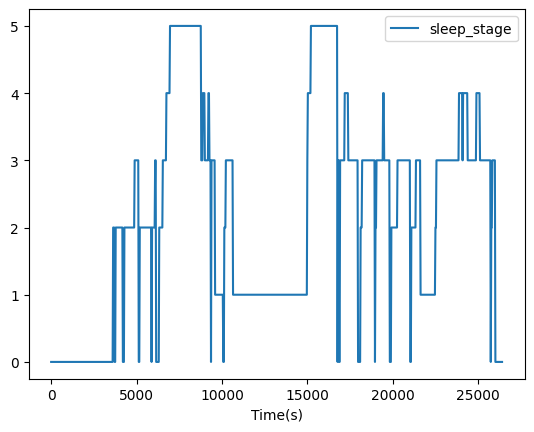

In [188]:
foo.plot(y='sleep_stage', x='Time(s)')